# Inversion of DC IP data at the Century Deposit


Northeastern Australia (Mt. Isa region) 

Zinc-lead-silver deposit is located 250 km to the NNW of Mt Isa and 375 km SW of McArthur River (#Location: 18° 43' 15"S, 138° 35' 54"E).

- [geologic background](http://www.portergeo.com.au/database/mineinfo.asp?mineid=mn075)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets

import discretize

from SimPEG import Data, maps
from SimPEG.electromagnetics import resistivity as dc

## Data
- dipole-dipole survey

In [2]:
dc_data_file = "./century/46800POT.OBS"

In [3]:
!cat {dc_data_file}

AVG-GDAT 1.22: CENTURY Converted by RES2POT to conductivitie
   27    1    1
    26000.000000    26100.000000           2
   26700.0   26800.0    .00127    .00006
   26800.0   26900.0    .00080    .00004
    26100.000000    26200.000000           3
   26700.0   26800.0    .00164    .00008
   26800.0   26900.0    .00099    .00005
   26900.0   27000.0    .00063    .00003
    26200.000000    26300.000000           4
   26700.0   26800.0    .00252    .00013
   26800.0   26900.0    .00146    .00007
   26900.0   27000.0    .00088    .00004
   27000.0   27100.0    .00125    .00006
    26300.000000    26400.000000           5
   26700.0   26800.0    .00504    .00025
   26800.0   26900.0    .00260    .00013
   26900.0   27000.0    .00147    .00007
   27000.0   27100.0    .00195    .00010
   27100.0   27200.0    .00103    .00005
    26400.000000    26500.000000           6
   26700.0   26800.0    .01048    .00052
   26800.0   26900.0    .00472    .00024
   26900.0   27000.0    .00249    .00012
 

In [4]:
def read_dcip_data(filename):
    """
    Read in a .OBS file from the Century data set into a python dictionary. 
    The format is the old UBC-GIF DCIP format.
    
    Parameters
    ----------
    filename : str
        Path to the file to be parsed
    
    
    Returns
    -------
    dict
        A dictionary with the locations of
        - a_locations: the positive source electrode locations (numpy array) 
        - b_locations: the negative source electrode locations (numpy array) 
        - m_locations: the receiver locations (list of numpy arrays)
        - n_locations: the receiver locations (list of numpy arrays)
        - n_locations: the receiver locations (list of numpy arrays)
        - observed_data: observed data (list of numpy arrays)
        - standard_deviations: assigned standard deviations (list of numpy arrays)
        - n_sources: number of sources (int)
    
    """
    
    # read in the text file as a numpy array of strings (each row is an entry)
    contents = np.genfromtxt(filename, delimiter=' \n', dtype=np.str)
    
    # the second line has the number of sources, current, and data type (voltages if 1)
    n_sources = int(contents[1].split()[0])
    print(f"number of sources: {n_sources}")
    
    # initialize storage for the electrode locations and data
    a_locations = np.zeros(n_sources)
    b_locations = np.zeros(n_sources)
    m_locations = []
    n_locations = []
    observed_data = []
    standard_deviations = []
    
    # index to track where we have read in content 
    content_index = 1 
    
    # loop over sources 
    for i in range(n_sources):
        # start by reading in the source info 
        content_index = content_index + 1  # read the next line
        a_location, b_location, nrx = contents[content_index].split()  # this is a string

        # convert the strings to a float for locations and an int for the number of receivers
        a_locations[i] = float(a_location)
        b_locations[i] = float(b_location)
        nrx = int(nrx)

        print(f"Source {i}: A-loc: {a_location}, B-loc: {b_location}, N receivers: {nrx}")

        # initialize space for receiver locations, observed data associated with this source
        m_locations_i, n_locations_i = np.zeros(nrx), np.zeros(nrx)
        observed_data_i, standard_deviations_i = np.zeros(nrx), np.zeros(nrx)

        # read in the receiver info 
        for j in range(nrx):
            content_index = content_index + 1  # read the next line
            m_location, n_location, datum, std = contents[content_index].split()

            # convert the locations and data to floats, and store them
            m_locations_i[j] = float(m_location)
            n_locations_i[j] = float(n_location)
            observed_data_i[j] = float(datum)
            standard_deviations_i[j] = float(std)

        # append the receiver info to the lists
        m_locations.append(m_locations_i)
        n_locations.append(n_locations_i)
        observed_data.append(observed_data_i)
        standard_deviations.append(standard_deviations_i)
    
    return {
        "a_locations": a_locations,
        "b_locations": b_locations, 
        "m_locations": m_locations,
        "n_locations": n_locations,
        "observed_data": observed_data, 
        "standard_deviations": standard_deviations,
        "n_sources": n_sources, 
    }

In [5]:
# sanity check 
dc_data_dict = read_dcip_data(dc_data_file)

number of sources: 27
Source 0: A-loc: 26000.000000, B-loc: 26100.000000, N receivers: 2
Source 1: A-loc: 26100.000000, B-loc: 26200.000000, N receivers: 3
Source 2: A-loc: 26200.000000, B-loc: 26300.000000, N receivers: 4
Source 3: A-loc: 26300.000000, B-loc: 26400.000000, N receivers: 5
Source 4: A-loc: 26400.000000, B-loc: 26500.000000, N receivers: 6
Source 5: A-loc: 26500.000000, B-loc: 26600.000000, N receivers: 7
Source 6: A-loc: 26600.000000, B-loc: 26700.000000, N receivers: 7
Source 7: A-loc: 26700.000000, B-loc: 26800.000000, N receivers: 6
Source 8: A-loc: 26800.000000, B-loc: 26900.000000, N receivers: 6
Source 9: A-loc: 26900.000000, B-loc: 27000.000000, N receivers: 6
Source 10: A-loc: 27000.000000, B-loc: 27100.000000, N receivers: 6
Source 11: A-loc: 27100.000000, B-loc: 27200.000000, N receivers: 6
Source 12: A-loc: 27200.000000, B-loc: 27300.000000, N receivers: 6
Source 13: A-loc: 27300.000000, B-loc: 27400.000000, N receivers: 6
Source 14: A-loc: 27400.000000, B-lo

## Create a SimPEG survey

In [6]:
source_list = []

for i in range(dc_data_dict["n_sources"]):
    m_locs = np.vstack([
        dc_data_dict["m_locations"][i], 
        np.zeros_like(dc_data_dict["m_locations"][i])
    ]).T
    n_locs = np.vstack([
        dc_data_dict["n_locations"][i],
        np.zeros_like(dc_data_dict["n_locations"][i])
    ]).T
    
    receivers = dc.receivers.Dipole(
        m_locations=m_locs, n_locations=n_locs,
    )
    
    source = dc.sources.Dipole(
        a_location=np.r_[dc_data_dict["a_locations"][i], 0.],
        b_location=np.r_[dc_data_dict["b_locations"][i], 0.],
        receiver_list=[receivers]
    )
    
    source_list.append(source)

In [7]:
survey = dc.Survey(source_list=source_list)

In [8]:
tmp = survey.source_list[0].receiver_list[0].locations

## Observed Data 

In [9]:
observed_data = Data(
    survey=survey, 
    dobs=np.hstack(dc_data_dict["observed_data"]),
    standard_deviation=np.hstack(dc_data_dict["standard_deviations"])
)

In [95]:
def plot_building_pseudosection(source_ind):
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    mid_x, mid_z = dc.utils.source_receiver_midpoints(observed_data.survey)
    ax.plot(mid_x, mid_z, '.k', alpha=0.5)
    
    # plot the source location
    a_loc = dc_data_dict["a_locations"][source_ind]
    b_loc = dc_data_dict["b_locations"][source_ind]
    src_mid = (a_loc+b_loc)/2
    ax.plot(np.r_[a_loc, b_loc], np.r_[0, 0], 'C0.')
    ax.plot(src_mid, np.r_[0], 'C0x', ms=6)

    # plot the receiver locations
    m_locs = dc_data_dict["m_locations"][source_ind]
    n_locs = dc_data_dict["n_locations"][source_ind]
    rx_mid = (m_locs+n_locs)/2
    ax.plot(np.r_[m_locs, n_locs], np.zeros(2*len(m_locs)), 'C1.')
    ax.plot(rx_mid, np.zeros_like(m_locs), 'C1x', ms=6)
    
    # plot where the pseudosection points should be 
    pseudo_x = (rx_mid + src_mid)/2.
    pseudo_z = -np.abs(rx_mid-src_mid)/2.
    
    ax.plot(np.r_[src_mid, pseudo_x], np.r_[0, pseudo_z], '-k', alpha=0.3)
    
    for rx_x, px, pz in zip(rx_mid, pseudo_x, pseudo_z): 
        ax.plot(np.r_[px, rx_x], np.r_[pz, 0], '-k', alpha=0.3)
        
    ax.plot(pseudo_x, pseudo_z, 'C2o')
    
    ax.set_xlim([25900, 29200])
    ax.set_aspect(1.5)
    

In [96]:
ipywidgets.interact(
    plot_building_pseudosection, 
    source_ind=ipywidgets.IntSlider(min=0, max=int(dc_data_dict["n_sources"]), value=0)
)

interactive(children=(IntSlider(value=0, description='source_ind', max=27), Output()), _dom_classes=('widget-i…

<function __main__.plot_building_pseudosection(source_ind)>

/Users/lindseyjh/git/python_symlinks/SimPEG/electromagnetics/static/utils/static_utils.py:423: MatplotlibDeprecationWarning: 
The get_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.get_clim instead.
  cmin, cmax = cbar.get_clim()


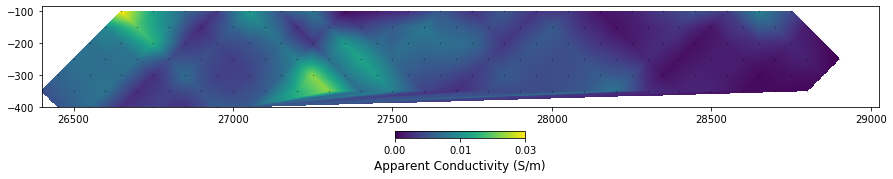

In [45]:
# plot psuedosection
dc.utils.plot_pseudosection(observed_data, data_location=True)

In [11]:
# forward simulation 

In [12]:
# run the forward simulation over the half-space & plot apparent resistivities

In [13]:
# set up inversion 

In [14]:
# run inversion, plot tikhonov curves

In [15]:
# (depth of investigation?)

In [16]:
# repeat for IP